In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Udem/DKL

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Udem/DKL


In [2]:
!pip install gpytorch
!pip install optuna

In [3]:
import pandas as pd
import numpy as np
import os
import torch
import torch.optim as optim
from features import feature_prep, inverse_transform, format_predictions, calculate_metrics
# from features import SequenceEncoder
from model import LSTMModel, ExactGPLayer,DeepGP, MLPModel, Bias, GPModel, WaveNet, ConvRNN
from run_exp import Optimization

import matplotlib.pyplot as plt
import torch.nn as nn
import gpytorch
from gpytorch.mlls import VariationalELBO, AddedLossTerm
from gpytorch.mlls import DeepApproximateMLL
import time
import optuna
import pickle
from torch.utils.data import TensorDataset, DataLoader
from sklearn.ensemble import RandomForestRegressor
# from mapie.metrics import (regression_coverage_score, regression_mean_width_score)
# from mapie.regression import MapieRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from scipy.stats import randint
from sklearn.metrics import mean_absolute_error
import random


In [4]:
torch.__version__

'2.0.1+cu118'

In [5]:
!python -V

Python 3.10.12


In [6]:
!nvidia-smi

Sat Jul  8 09:01:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
df = pd.read_csv('data.csv')

In [13]:
ind = int(df.shape[0]*80/100)
# train = df[(df['type']=='train')] in case of taking whole dataset
train = df[(df['type']=='dev_in')]
val = df[(df['type']=='dev_in')]
test = df[(df['type']=='dev_out')].iloc[:-3700,:]
#test = df[((df['type']=='dev_out'))] # for hyperparameter tuning we use validation data

In [14]:
features = ['draft_aft_telegram', 'draft_fore_telegram', 'stw',
    'diff_speed_overground', 'awind_vcomp_provider', 'awind_ucomp_provider',
    'rcurrent_vcomp', 'rcurrent_ucomp', 'comb_wind_swell_wave_height',
    'timeSinceDryDock']
X_train = train[features]
y_train = train['power']
X_test = test[features]
y_test = test['power']

In [15]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
def get_model(model, model_params):
    models = {
        "convrnn": ConvRNN,
        "wavenet": WaveNet,
        "lstm": LSTMModel,
        "mlp": MLPModel,
        "bias": Bias
    }
    return models.get(model.lower())(**model_params)

def initialize_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_uniform_(m.weight.data).to(device)
        nn.init.constant_(m.bias.data, 0).to(device)

def get_model_likelihood_mll(train_x=None, train_y=None, batch_size=64, input_dim=32, device=torch.device("cpu"), mode = 'ExactGP', kernel='RBF'):
    # noise_prior = gpytorch.priors.Prior()
    likelihood = gpytorch.likelihoods.GaussianLikelihood()
    if (train_x is None): train_x = torch.ones(batch_size, input_dim).to(device)
    if (train_y is None): train_y = torch.ones(batch_size).to(device)
    model = ExactGPLayer(train_x,train_y,likelihood, kernel=kernel)
    return model, likelihood



In [11]:
#!unset LD_LIBRARY_PATH
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)


In [16]:
start_time = time.time()

batch_size = 256
X_train, y_train, train_features, train_targets, X_test,y_test, scaler, scaler1, train_loader,val_loader, test_loader, train_loader_one, test_loader_one = feature_prep(train, val, test, batch_size=batch_size)

device = torch.device("cuda")
input_dim = X_train.shape[1]
output_dim = 1
hidden_dim = 100
layer_dim = 3
kernel = 1
out_channels = 24

dropout = 0.3968084179060663
n_epochs = 50
learning_rate = 0.001
weight_decay = 1e-6

model_params = {'input_dim': input_dim,
                'hidden_dim': hidden_dim,
                'layer_dim': layer_dim,
                'output_dim': output_dim,
                'dropout_prob': dropout,
                'device': device}

mlp_params = {'input_dim': input_dim, 'hidden_dim': hidden_dim, 'output_dim': output_dim}
bias_params = {'input_dim': output_dim, 'output_dim': output_dim, 'device': device}
convrnn_params = {'input_dim':input_dim, 'timesteps':X_train.shape[1], 'output_dim':output_dim, 'kernel_size1':7, 'kernel_size2':5, 'kernel_size3':3,
              'n_channels1':32, 'n_channels2':32, 'n_channels3':32, 'n_units1':32, 'n_units2':32, 'n_units3':32}
mode = 'LSTM_ExactGP'
#options:{LSTM_ExactGP, DeepGP, ExactGP, mlp_ExactGP}

if mode == 'LSTM_ExactGP': # LSTM_ExactGP
    feature_extractor = get_model('lstm', model_params)
    feature_extractor.to(device)
    model, likelihood = get_model_likelihood_mll(train_x=None, train_y=None, batch_size=batch_size,
                                                  input_dim=output_dim, device=device, mode=mode)
    loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    feature_extractor.apply(initialize_weights)
    model.to(device)
else:

    feature_extractor = get_model('mlp', mlp_params)
    feature_extractor.to(device)

    model, likelihood = get_model_likelihood_mll(train_x=None, train_y=None, batch_size=batch_size,input_dim=output_dim, device=device, mode=mode)
    model.to(device)
    likelihood.to(device)
    loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    feature_extractor.apply(initialize_weights)


likelihood.to(device)
lr = 0.00177040768495762

optimizer = torch.optim.Adam([
    {'params': feature_extractor.parameters(), 'lr': lr},
    {'params': model.covar_module.parameters(), 'lr': lr * 0.1},
    {'params': model.mean_module.parameters(), 'lr': lr},
    {'params': likelihood.parameters(), 'lr': lr}, ])

opt = Optimization(feature_extractor=feature_extractor, model=model, likelihood=likelihood, loss_fn=loss_fn, optimizer=optimizer, device=device, mode=mode)
opt.train(train_loader,val_loader, batch_size=batch_size, n_epochs=n_epochs, n_features=input_dim)
opt.plot_losses()

predictions, values,variance, lower_pred, upper_pred, mean_f, lower_f, upper_f= opt.evaluate(train_loader,test_loader_one, batch_size=1, n_features=input_dim)

df_result = format_predictions(predictions,values,variance, lower_pred, upper_pred, mean_f, lower_f, upper_f, scaler1)
df_result.to_csv('results.csv', index=True)

plt.figure(figsize=(20, 4))
plt.plot(df_result.tail(200)['prediction'], label="predicted")
plt.plot(
    df_result.tail(200)['actual'], label="actual"
)

plt.xlabel("Date")
plt.ylabel("Target values")
plt.legend()
plt.savefig("Predictions.png")
plt.close()
plt.figure(figsize=(20, 4))
plt.plot(
    df_result.head(200)['prediction'], label="predicted"
)

plt.plot(
    df_result.head(200)['actual'], label="actual"
)

plt.xlabel("Date")
plt.ylabel("Target values")
plt.legend()
plt.savefig("Predictions1.png")
plt.close()

print('Overall time taken(in hours):',(time.time()-start_time)/3600)
result_metrics = calculate_metrics(df_result)
print('metrics',result_metrics)

plt.figure(figsize=(20, 6))
plt.plot(df_result.index, df_result['prediction'], 'b')
plt.fill_between(df_result.index, df_result['lower_pred'], df_result['upper_pred'], alpha=0.5)
plt.legend(['Mean', '95% Confidence'], fontsize=16)
plt.tick_params(axis='both', which='major', labelsize=16)
plt.tick_params(axis='both', which='minor', labelsize=16)
plt.tight_layout()
plt.savefig("Predictions2.png")
plt.close()


Identified outliers: 0
Non-outlier observations: 18108


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/loss.py:536: UserWarning: Using a target size (torch.Size([1, 256])) that is different to the input size (torch.Size([256])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


[1/50] Training loss:  0.8655 - noise =  6.313301e-01 	 train_mse:  1.0015
[2/50] Training loss:  0.7343 - noise =  5.701013e-01 	 train_mse:  1.0105
[3/50] Training loss:  0.6806 - noise =  5.144445e-01 	 train_mse:  1.0144
[4/50] Training loss:  0.6296 - noise =  4.632683e-01 	 train_mse:  1.0180
[5/50] Training loss:  0.5794 - noise =  4.162768e-01 	 train_mse:  1.0212
[6/50] Training loss:  0.5291 - noise =  3.732862e-01 	 train_mse:  1.0245
[7/50] Training loss:  0.4780 - noise =  3.340697e-01 	 train_mse:  1.0266
[8/50] Training loss:  0.4273 - noise =  2.984886e-01 	 train_mse:  1.0290
[9/50] Training loss:  0.3755 - noise =  2.663015e-01 	 train_mse:  1.0315
[10/50] Training loss:  0.3247 - noise =  2.373488e-01 	 train_mse:  1.0343
[20/50] Training loss: -0.1408 - noise =  7.605354e-02 	 train_mse:  1.0441
[30/50] Training loss: -0.3840 - noise =  3.224412e-02 	 train_mse:  1.0285
[40/50] Training loss: -0.4058 - noise =  2.333292e-02 	 train_mse:  1.0000


/usr/local/lib/python3.10/dist-packages/linear_operator/utils/cholesky.py:40: NumericalWarning: A not p.d., added jitter of 1.0e-01 to the diagonal
  warnings.warn(


[50/50] Training loss: -0.4399 - noise =  2.127137e-02 	 train_mse:  0.9971
Wall clock(in hours): 0.011515803469551934
Overall time taken(in hours): 0.046326500376065574
metrics {'mae': 1108.1865397399347, 'mse': 1439.5454971845188, 'r2': 0.9225088288242748}


epoch 5 -- <br>
'mae': 7294.9536, 'mse': 8646.500332504474, 'r2': -0.2560024757412851 --batch size: 64,
<br>
'mae': 6085.7246, 'mse': 7291.57431560565, 'r2': 0.10679254322661347 --batch size 128 <br>
metrics {'mae': 2796.614, 'mse': 4432.232394629144, 'r2': 0.6699689787529934} --batch 256
<br>
metrics {'mae': 3227.2485, 'mse': 5373.223055113197, 'r2': 0.5149579093542741} --batch 400 <br>
epoch 50 -- on test data<br>
at 256 batch size:<br>
metrics {'mae': 2784.4573, 'mse': 3412.797239801978, 'r2': 0.5970116483041608} -- spectral kernel<br>
epoch 10
metrics {'mae': 2880.4158, 'mse': 3518.38272505991, 'r2': 0.5716905634503842}
epoch 100 <br>
{'mae': 2751.2856, 'mse': 3455.934316505451, 'r2': 0.5867598963428131}
<br>
'RBF kernel'


Plot error metric

In [17]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('seaborn-whitegrid')
import numpy as np
import pandas as pd
results = pd.read_csv('results.csv').rename(columns = {'Unnamed: 0':'Time_Index'})#.head(1000)
results.head()

<ipython-input-17-87e7a2d62554>:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


,Time_Index,actual,prediction,variance,lower_likelihood,upper_likelihood,mean_pred,lower_pred,upper_pred
0,0,21346.588987,20095.922912,18193.862235,17642.733461,22549.112132,20095.922912,19119.433626,21072.412197
1,1,19979.905858,18892.308519,18192.094075,16450.266065,21334.350974,18892.308519,17944.170956,19840.446082
2,2,21432.773110,21143.976005,18194.604448,18686.122659,23601.829121,21143.976005,20155.827900,22132.124341
3,3,19120.396917,18297.717411,18190.780256,15863.990627,20731.444253,18297.717411,17371.208108,19224.226772
4,4,19665.235099,18648.222412,18191.595587,16209.331606,21087.113218,18648.222412,17708.232411,19588.212413


In [21]:
def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = np.finfo(np.float64).eps
    mape = np.abs(y_pred - y_true) / (np.abs(y_true)+np.abs(y_pred))#np.maximum(np.abs(y_true), epsilon)
    output_errors = np.average(mape, axis=0)
    return np.average(output_errors)
mean_absolute_percentage_error(results['actual'], results['prediction'])

0.039954978151202476

(array([-5000.,     0.,  5000., 10000., 15000., 20000., 25000., 30000.,
        35000.]),
 [Text(0, -5000.0, '−5000'),
  Text(0, 0.0, '0'),
  Text(0, 5000.0, '5000'),
  Text(0, 10000.0, '10000'),
  Text(0, 15000.0, '15000'),
  Text(0, 20000.0, '20000'),
  Text(0, 25000.0, '25000'),
  Text(0, 30000.0, '30000'),
  Text(0, 35000.0, '35000')])

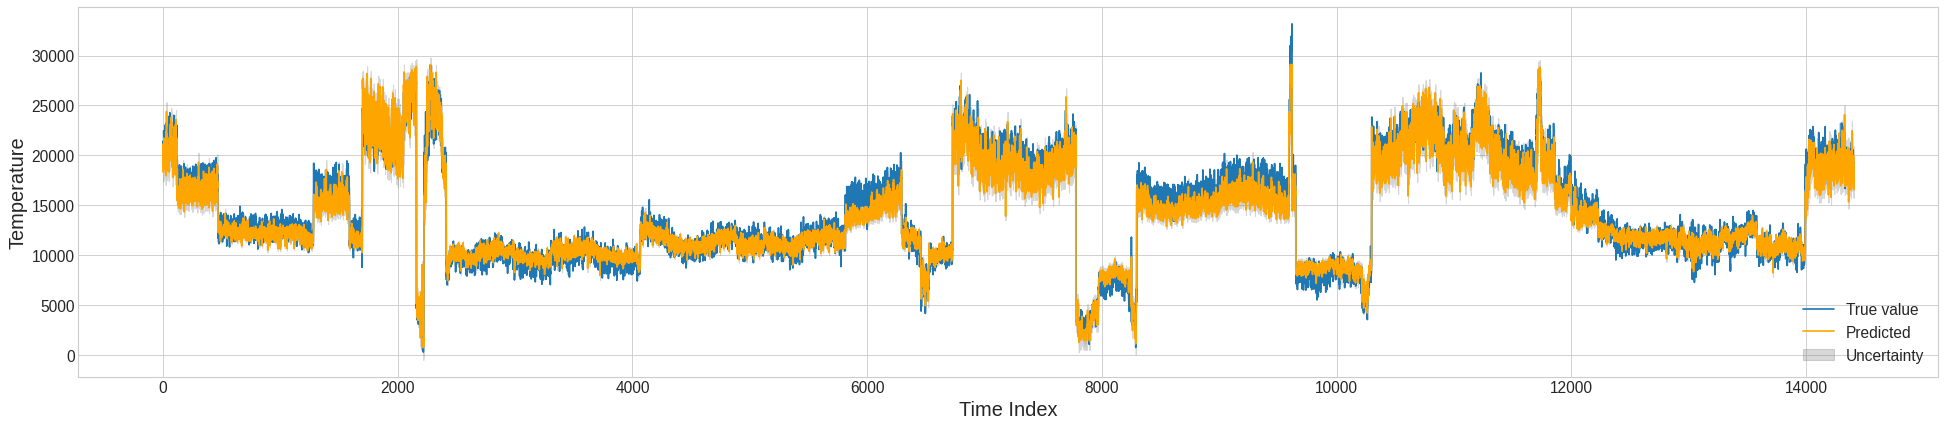

In [19]:
plt.figure(figsize=(30, 6), dpi=80)
plt.plot(results['Time_Index'], results['actual'], '-', label='True value')

plt.plot(results['Time_Index'], results['prediction'], '-', color='orange', label='Predicted')

plt.fill_between(results['Time_Index'], results['lower_pred'], results['upper_pred'],
                 color='gray', alpha=0.3, label='Uncertainty')
plt.legend(fontsize=14, loc = 'lower right')
plt.xlabel('Time Index',fontsize=18)
plt.ylabel('Temperature', fontsize=18)
plt.xticks(fontsize=14, )
plt.yticks(fontsize=14, )

#### Hyperparameter tuning

In [ ]:
def objective(trial):

    params = {
              'learning_rate': trial.suggest_loguniform('learning_rate', 1e-5, 1e-1),
              'optimizer': trial.suggest_categorical("optimizer", ["Adam", "RMSprop", "SGD"]),
              'batch_size': trial.suggest_categorical("batch", [64, 128, 256]),
              'dropout':trial.suggest_loguniform('dropout', 0.1, 0.4),
              'kernel':trial.suggest_categorical("kernel", ['RBF', 'spectral', 'cosine', 'matern', 'BNCosSim']),
              }
    features = ['draft_aft_telegram', 'draft_fore_telegram', 'stw',
    'diff_speed_overground', 'awind_vcomp_provider', 'awind_ucomp_provider',
    'rcurrent_vcomp', 'rcurrent_ucomp', 'comb_wind_swell_wave_height',
    'timeSinceDryDock']
    X_train = train[features]
    y_train = train['power']
    X_test = test[features]
    y_test = test['power']

    X_train, y_train, train_features, train_targets, X_test,y_test, scaler, scaler1, train_loader,val_loader, test_loader, train_loader_one, test_loader_one = feature_prep(train, val, test, batch_size=params["batch_size"])
    device = torch.device("cuda")
    input_dim = X_train.shape[1]
    output_dim = 1
    hidden_dim = 100
    layer_dim = 3
    kernel = 1
    out_channels = 24
    mode = 'LSTM_ExactGP'
    dropout = params['dropout']
    n_epochs = 1
    learning_rate = 0.001
    weight_decay = 1e-6

    model_params = {'input_dim': input_dim,
                    'hidden_dim': hidden_dim,
                    'layer_dim': layer_dim,
                    'output_dim': output_dim,
                    'dropout_prob': dropout,
                    'device': device}
    feature_extractor = get_model('lstm', model_params)
    feature_extractor.to(device)
    model, likelihood = get_model_likelihood_mll(train_x=None, train_y=None, batch_size=params["batch_size"],
                                                  input_dim=output_dim, device=device, mode=mode, kernel = params["kernel"])
    loss_fn = gpytorch.mlls.ExactMarginalLogLikelihood(likelihood, model)
    feature_extractor.apply(initialize_weights)
    model.to(device)
    # optim_params = list(feature_extractor.parameters()) + list(model.covar_module.parameters()) + list(model.mean_module.parameters()) + list(likelihood.parameters())
    # learn_params = list(lr) + list(lr*0.1) + list(lr) + list(lr)
    # optimizer = getattr(torch.optim, params['optimizer'])([feature_extractor.parameters(), lr= params['learning_rate']])

    optimizer = getattr(torch.optim, params['optimizer'])([
    {'params': feature_extractor.parameters(), 'lr': params['learning_rate']},
    {'params': model.covar_module.parameters(), 'lr': params['learning_rate'] * 0.1},
    {'params': model.mean_module.parameters(), 'lr': params['learning_rate']},
    {'params': likelihood.parameters(), 'lr': params['learning_rate']}, ])

    opt = Optimization(feature_extractor=feature_extractor, model=model, likelihood=likelihood, loss_fn=loss_fn, optimizer=optimizer, device=device, mode=mode)
    opt.train(train_loader,val_loader, batch_size=params["batch_size"], n_epochs=n_epochs, n_features=input_dim)
    predictions, values,variance, lower_pred, upper_pred, mean_f, lower_f, upper_f = opt.evaluate(train_loader, test_loader_one, batch_size=1, n_features=input_dim)
    df_result = format_predictions(predictions,values,variance, lower_pred, upper_pred, mean_f, lower_f, upper_f, scaler1)
    # print('values',np.concatenate(values, axis=0).ravel().shape)
    # print('prediction',np.concatenate(predictions, axis=0).ravel().shape)
    # mae_mean = mean_absolute_error(np.concatenate(values, axis=0).ravel(), np.concatenate(predictions, axis=0).ravel())
    result_metrics = calculate_metrics(df_result)
    return result_metrics["mae"]


In [ ]:
%%time
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=10)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

In [ ]:
# 1epoch: 'mae': 1260.5171, 'mse': 1578.8270171237887, 'r2': 0.9137536772367476 batch active learning
#100 epochs: 'mae': 5453.195, 'mse': 6785.376923944608, 'r2': 0.2265047417595234
#200 epochs metrics {'mae': 4877.8594, 'mse': 6272.694158015358, 'r2': 0.3389748865544878}
#100 epochs with transformer encoder metrics {'mae': 6439.92, 'mse': 7715.523313424696, 'r2': -9.323326833987622e-05}
#Area under Mean Square error (MSE) and F1 retention curves [Malinin, 2019, Malinin et al., 2021] is used to assess jointly the robustness to distributional shift and uncertainty quality.